In [1]:
import pandas as pd
from datetime import timedelta

import data_preprocessing
from models import regression_model
from conformal_prediction import EnCQR
import utils

First, we specify several configuration hyperparameters and we store them in a dictionary.
Not all of them are used at the same time. For example, if we decide to use an LSTM model, the parameters that specifies the TCN and RF model are not used. 

In [2]:
target_idx = [0]            # target variables to predict
B = 3                       # number of ensembles
alpha = 0.1                 # confidence level            
quantiles = [alpha/2,       # quantiles to predict
             0.5,
             1-(alpha/2)] 
model_type = 'tcn'          # options: {'rf', 'lstm', 'tcn'}

# rf only
n_trees = 20                # number of trees in each rf model

# lstm and tcn only
regression = 'quantile'     # options: {'quantile', 'linear'}. If 'linear', just set one quantile
l2_lambda = 1e-4            # weight of l2 regularization in the lstm and tcn models
batch_size = 16             # size of batches using to train the lstm and tcn models

# lstm only
units = 128                 # number of units in each lstm layer
n_layers = 3                # number of lstm layers in the model

# tcn only
dilations = [1,2,4,8]       # dilation rate of the Conv1D layers
n_filters = 128             # filters in each Conv1D layer 
kernel_size = 7             # kernel size in each ConvID layer

# Store the configuration in a dictionary
P = {'B':B, 'alpha':alpha, 'quantiles':quantiles, 'model_type':model_type,
     'n_trees':n_trees,  
     'regression':regression,'l2':l2_lambda, 'batch_size':batch_size,
     'units':units,'n_layers':n_layers,
     'dilations':dilations, 'n_filters':n_filters, 'kernel_size':kernel_size}

### Data loading
For this example, we will use 3 years of data relative to solar power production.
We will use the first year for training, the second for validation, and the last year as test set.

**Important:** The data must be provided as a DataFrame with date and hours as index.

In [3]:
url = 'https://raw.githubusercontent.com/Duvey314/austin-green-energy-predictor/master/Resources/Output/Webberville_Solar_2017-2020_MWH.csv'
df = pd.read_csv(url)
df = df.drop(columns=('Weather_Description'))
df = df.drop(columns=('Year'))
df = df.drop(columns=('Month'))
df = df.drop(columns=('Day'))
df = df.drop(columns=('Hour'))
df = df.drop(columns=('Date_Time'))

# create date+hour index 
date_list = pd.date_range(start='01/01/2017', end='31/07/2020')
date_list = pd.to_datetime(date_list)
hour_list = []
for nDate in date_list:
    for nHour in range(24):
        tmp_timestamp = nDate+timedelta(hours=nHour)
        hour_list.append(tmp_timestamp)
date_list = pd.to_datetime(hour_list) 
df['hour_list'] = date_list[:-1]
df = df.set_index('hour_list')

# train, val, test datasets
df_train = df[0:365*24]
df_val = df[365*24:365*24*2]
df_test = df[365*24*2:365*24*3]

### Data preprocessing

First, we want to rescale each variable in \[0,1\], so we initialize the scaler on the training data.

We organize the datasets in 3-dimensional arrays with dimensions \[*number of samples*, *time steps*, *number of variables* \].
The input data, X, might have a different number of time steps and a different number of variables than the output data, Y. In this case, we want to predict the energy consumption for the next day. Therefore, the second dimension of X is ``time_steps_in=168`` (hours in the past week) and the second dimension of Y is ``time_steps_out=24`` (hours of the next day). As input we use the hsitorical energy production plus 5 exogenous variables, so ``n_vars=6`` in X. Since we want to predict the future energy production, ``n_vars=1`` in Y.

In addition, we split the training data in B disjoint sets to train the ensemble model. In this case, ``B=3``.

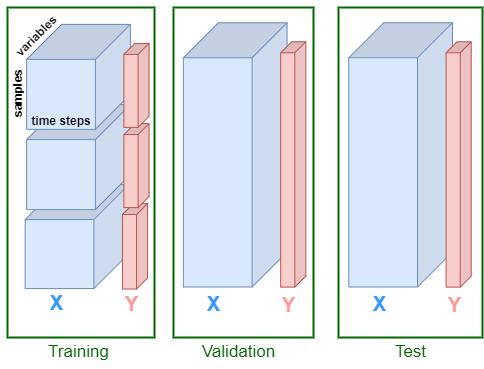

In [4]:
# Initialize the scaler
Scaler = data_preprocessing.xy_scaler()
Scaler.fit(df_train.values, target_idx)

# split into input-output pairs
train_data = data_preprocessing.create_datasets(df_train, target_idx=target_idx, scaler=Scaler, B=B) 
val_x, val_y = data_preprocessing.create_datasets(df_val, target_idx=target_idx, scaler=Scaler)
test_x, test_y = data_preprocessing.create_datasets(df_test, target_idx=target_idx, scaler=Scaler)

# Print the shapes of the datasets
print("-- Training data --")
for i in range(len(train_data)):
    print(f"Set {i} - x: {train_data[i][0].shape}, y: {train_data[i][1].shape}")
print("-- Validation data --")
print(f"x: {val_x.shape}, y: {val_y.shape}")
print("-- Test data --")
print(f"x: {val_x.shape}, y: {val_y.shape}")

# Update configuration dict
P['time_steps_in'] = test_x.shape[1]
P['n_vars'] = test_x.shape[2] 
P['time_steps_out'] = test_y.shape[1]

-- Training data --
Set 0 - x: (115, 168, 6), y: (115, 24)
Set 1 - x: (115, 168, 6), y: (115, 24)
Set 2 - x: (115, 168, 6), y: (115, 24)
-- Validation data --
x: (358, 168, 6), y: (358, 24)
-- Test data --
x: (358, 168, 6), y: (358, 24)


### Training the quantile regression models

Before looking into the conformalization of the PI, let's see how we can train different models that perform quantile regression.

In the paper we considered three models:
- a random forest (rf)
- a recurrent neural network with LSTM cells
- a feedforward neural network with 1-dimensional convolutional cells (TCN).

In principle, any other model performing quantile regression can be used. Each model must implement a ``fit()`` function with is used to train the model parameters and a ``transform()`` function used to predict new data.
The ``fit()`` function uses ``val_x`` and ``val_y`` to perform early stopping.

Let's start with the **TCN** model.

<Figure size 432x288 with 0 Axes>

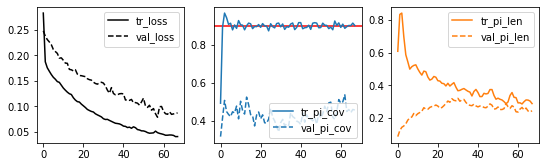

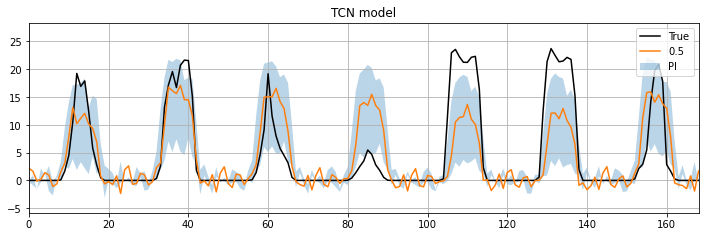

In [5]:
P['model_type'] = 'tcn' 

# Train 
model = regression_model(P)
hist = model.fit(train_data[0][0], train_data[0][1], val_x, val_y)
utils.plot_history(hist)

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='TCN model')

The function ``plot_hist()`` plots how the loss, coverage, and PI length evolve during training on the train and validation set.
Note that here we trained the model only on the first subset of the training set.

Next we train the **LSTM** model. It is sufficient to just change ``model_type`` in the hyperparameters dictionary. The rest is unchanged.

<Figure size 432x288 with 0 Axes>

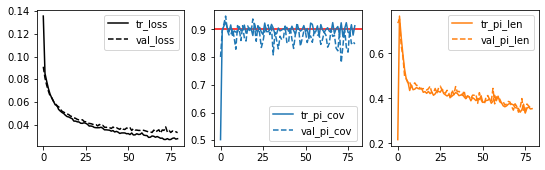

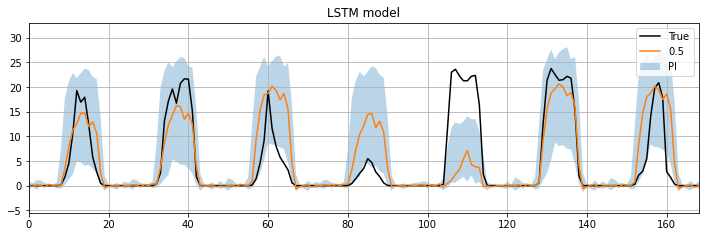

In [6]:
P['model_type'] = 'lstm'

# Train
model = regression_model(P)
hist = model.fit(train_data[0][0], train_data[0][1], val_x, val_y)
utils.plot_history(hist)

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='LSTM model')

Finally, we train the **RF** model. As before,  ``model_type`` in the hyperparameters dictionary. Contrairly to the previous two neural network model, the ``fit()`` function does not use ``val_x`` and ``val_y`` since there is no early stopping.

<Figure size 432x288 with 0 Axes>

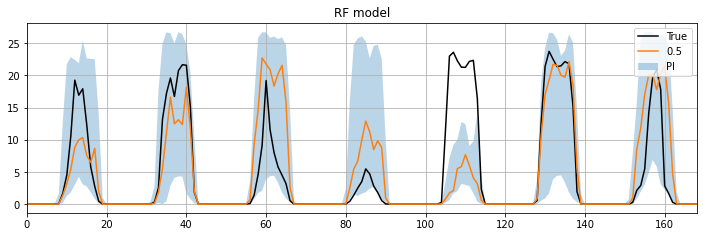

In [7]:
# Train
P['model_type'] = 'rf'
model = regression_model(P)
model.fit(train_data[0][0], train_data[0][1])

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='RF model')

### EnCQR

To conclude, we compute the intervals with the EnCQR method.

It is sufficient to call the function ``conformalized_PI()``, which returns two intervals:
- the PI computed by the ensemble of QR models
- the conformalized PI

In this example, we consider the TCN model and show that after conformalization the coverage of the PI gets much closer to the desired confidence level.

In [ ]:
P['model_type'] = 'tcn'

# compute the conformalized PI with EnCQR
PI, conf_PI = EnCQR(train_data, val_x, val_y, test_x, test_y, P)

# Plot original and conformalized PI
utils.plot_PIs(test_y, PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2],
               x_lims=[0,168], scaler=Scaler)

# Compute PI coverage and length before and after conformalization
print("Quantile regression:")
utils.compute_coverage_len(test_y.flatten(), PI[:,:,0].flatten(), PI[:,:,2].flatten(), verbose=True)
print("EnCQR:")
utils.compute_coverage_len(test_y.flatten(), conf_PI[:,:,0].flatten(), conf_PI[:,:,2].flatten(), verbose=True)